In [42]:
#Load all the necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import os

import re
from io import StringIO
from matplotlib import pyplot
from matplotlib import image
import natsort
from PIL import Image
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, BertPreTrainedModel
from typing import Tuple, List
from functools import partial
from sklearn.preprocessing import MultiLabelBinarizer

import time
from tqdm.notebook import tqdm

random_seed= 0

In [43]:
# check if GPU is available
train_mode = torch.cuda.is_available()
if not train_mode: print('use CPU')
else: print('Use GPU')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Use GPU


In [44]:
#define the bert model use in this project
bert_model_name = 'bert-base-uncased'

#use cuda if available
if torch.cuda.is_available():
    device = torch.device('cuda:0')

#use bert tokenizer as our tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

# Load Data

In [45]:
#load the train csv
train = 'train.csv'
test = 'test.csv'

#define our transformers: scale the data to (256,256), convert to tensor and normalise the data
transformers =  transforms.Compose([
                                    transforms.Scale((256,256)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485,0.456,0.406], 
                                                         std = [0.229,0.224,0.225])])

test_transformers = val_transformers =  transforms.Compose([transforms.Scale((224,224)),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(mean = [0.485,0.456,0.406], 
                                                                                 std = [0.229,0.224,0.225])])

#load the data
path = '../Input/'+train
with open(path) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

C:\Anaconda\envs\GPU-env\lib\site-packages\torchvision\transforms\transforms.py:210: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [46]:
df = df[df['Labels'] != '1']

In [47]:
#perform one hot encoding on labels
#We will use scikit's MultiLabelBinarizer to do the one hot encoding
dk = [np.fromstring(i, sep=' ',dtype=int) for i in df['Labels'].values]
label = []
for i in dk:
    label.append(i.tolist())

k = tuple(i for i in range(1,20))
mlb = MultiLabelBinarizer(classes=k)
res = mlb.fit_transform(label)

np.sum(res,0)

array([8720, 1162, 4364, 1272, 1130, 1394, 1221, 2210, 1042, 1471,  604,
          0,  605,  251, 1934, 1099, 1430, 1525, 1020])

In [48]:
# res_df = pd.DataFrame(res)

In [49]:
# df = pd.concat([df, res_df], axis=1)

# Data Preprocessing - ResNet

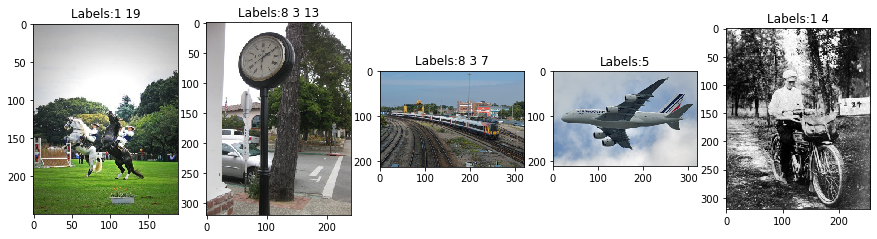

In [50]:
#print the first five images
fig,ax = plt.subplots(1,5,figsize = (15,5))
i = 0
for id in df['ImageID'][:5].values:
    path = '../Input/data/'+id
    axs = ax[i]
    axs.set_title('Labels:'+df['Labels'].values[i])
    axs.imshow(image.imread(path))
    i += 1

In [51]:
#Create function to load images based on list from train.csv
class LoadImages(Dataset):
    
    def __init__(self, data, label, path , transform = None, test = False):
        self.test = test
        self.data = data.values
        self.path = path
        self.transform = transform
        
        if not self.test:
            self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name = self.data[index]
        img_path = img_name
        image = Image.open(self.path+img_path)
        if self.transform is not None:
            image = self.transform(image)
        
        if not self.test:  
            label = self.label[index].astype(np.float32)
            label = torch.from_numpy(label)
            return image.to(device), label.to(device)
        
        else: return image.to(device)

In [52]:
## Pre split total data loading
data = LoadImages(df['ImageID'], res, '../Input/data/', None)
# splitting an shuffling for training and validation datasets
split_index = list(range(len(data)))
split = int(np.floor(0.3 * len(data)))
np.random.seed(random_seed)
np.random.shuffle(split_index)
train_index, val_index = split_index[split:], split_index[:split]

# if needed, shuffled sample of train/test (doesnt work with imshow function)
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(val_index)

train_data = LoadImages(df['ImageID'].iloc[train_index], res[train_index], '../Input/data/', transformers)
validation_data = LoadImages(df['ImageID'].iloc[val_index], res[val_index], '../Input/data/', val_transformers)

In [53]:
len(data),len(train_data),len(validation_data)

(15922, 11146, 4776)

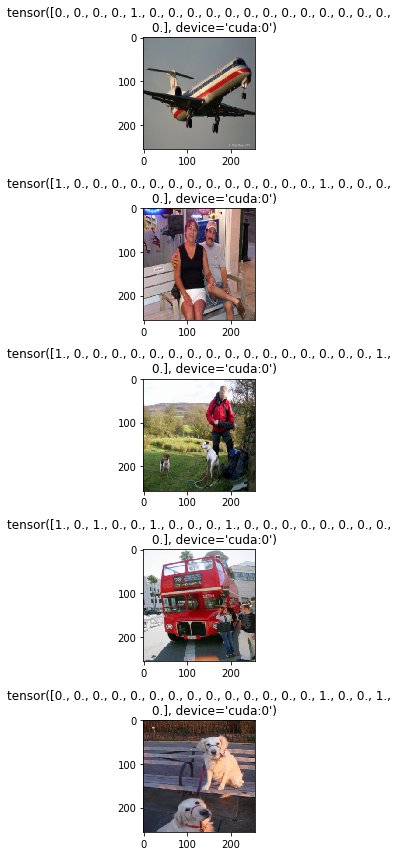

In [54]:
#define batch size ############################################################ test different batch size
batch_size=25
# #Use pytorch data loader function to change the data into format accepted by pytroch
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, num_workers=0)
validation_loader = DataLoader(dataset = validation_data, batch_size = batch_size, num_workers=0)

#Visualise the first five trian_loader images
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.detach().cpu().numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    return ax

#get the image and labels data from train loader
trainimages, trainlabels = next(iter(train_loader))

#visualise the images
fig, axes = plt.subplots(figsize=(12, 12), nrows=5)
for i in range(5):
    axe1 = axes[i] 
    axe1.set_title(trainlabels[i])
    imshow(trainimages[i], ax=axe1, normalize=True)
    plt.tight_layout()

In [55]:
print('Length of train loadder:',len(train_loader))

Length of train loadder: 446


In [56]:
print('\nTrain Image Shape:',trainimages.shape)
print('\nTrain Labels Shape:',trainlabels.shape)


Train Image Shape: torch.Size([25, 3, 256, 256])

Train Labels Shape: torch.Size([25, 19])


In [57]:
print('Length of validation loadder:',len(validation_loader))

Length of validation loadder: 192


In [58]:
valimages, vallabels = next(iter(validation_loader))
print('\nValidation Image Shape:',valimages.shape)
print('\nValidation Labels Shape:',vallabels.shape)


Validation Image Shape: torch.Size([25, 3, 224, 224])

Validation Labels Shape: torch.Size([25, 19])


# Data Preprocessing - BERT

In [59]:
# transform the dataset to Pytorch andd Bert accepted format
class LoadText(Dataset):
    
    def __init__(self, tokenizer, data, label, test = False):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.X = data
        self.test = test
        
        if not self.test:
            self.Y = label
        
    
    @staticmethod
    def row_to_tensor(tokenizer, row) -> Tuple[torch.LongTensor, torch.LongTensor]:
        tokens = tokenizer.encode(row, add_special_tokens=True)
        x = torch.LongTensor(tokens)
        return x
        
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        
        X = self.X[index]
        X = self.row_to_tensor(self.tokenizer, X)
        
        if not self.test:
            label = self.Y[index].astype(np.float32)
            Y = torch.from_numpy(label)
            return X.to(device), Y.to(device)
        
        else: return X.to(device),_

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], 
               device: torch.device) -> Tuple[torch.LongTensor, torch.LongTensor]:
    
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

collate_fn = partial(collate_fn, device=device)

train_dataset = LoadText(tokenizer, df['Caption'].iloc[train_index].values, res[train_index])
validation_dataset = LoadText(tokenizer, df['Caption'].iloc[val_index].values, res[val_index])

BATCH_SIZE = 25

train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
validation_iterator = DataLoader(validation_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [60]:
traindata, trainlabels = next(iter(train_iterator))
print('Train Data:\n',traindata[:10])
print('\nTrain Data Shape:',traindata.shape)

Train Data:
 tensor([[  101,  2093,  2003,  2019, 13297,  2008,  2003,  2055,  2000,  2455,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1037,  2450,  3564,  2006,  1037,  6847,  2279,  2000,  1037,
          2158,  1999,  1037,  6045,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  2158,  4520,  2039, 13215,  3941,  2096,  2010,  2048,  6077,
          2024,  5079,  2039,  2279,  2000,  2032,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1037,  3313,  5877,  2098,  3902,  7719,  9083,  2004,  2111,
          2202,  4620,   102,     0,     0,     0,     0,     

In [61]:
print('Train Labels:\n',trainlabels[:10])
print('\nTrain Labels Shape:',trainlabels.shape)

Train Labels:
 tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0.]], device='cuda:0')

Train Labels Sha

# Create Our Classifier

In [62]:
#create the function to build the model
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        #change output of both BERT and RESNET to 20 features each
        #Hence we have output of 40 features
        self.resnet = models.resnet50(pretrained = True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features,600)
        
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bertclassifier = nn.Linear(self.bert.config.hidden_size,600)
        
        self.fc1 = nn.Linear(1200, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 19)
    
    #define the forward function
    def forward(self,img, txt, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        output_resnet = self.resnet(img)

        output_bert = self.bert(txt,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        
        output_bert = self.bertclassifier(output_bert[1]) # batch, hidden

        output = torch.cat((output_resnet,output_bert),1)
    
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)

        return output

In [63]:
model = Classifier()

In [64]:
for param in model.parameters():
    param.requires_grad = False
    
for param in model.resnet.fc.parameters():
    param.requires_grad = True

for param in model.bertclassifier.parameters():
    param.requires_grad = True
    
for param in model.fc1.parameters():
    param.requires_grad = True
    
for param in model.fc2.parameters():
    param.requires_grad = True

for param in model.fc3.parameters():
    param.requires_grad = True

In [65]:
#Check if cuda is available
if torch.cuda.is_available():
    model = model.cuda()

def cuda(x):
    return x.cuda(non_blocking=True)

# will be use to create log for best models, params .etc.
def logger(str_to_log, need_print = True):
    if need_print:
        print(str_to_log)
    os.system('echo ' + str_to_log)

In [66]:
#F1 score scikit implementation
from sklearn.metrics import f1_score as sk_f1_score
def f1_score(y_true, y_pred):

    y_pred = torch.ge(y_pred.float(),0.41).float().detach().cpu().numpy()
    y_true = y_true.float().detach().cpu().numpy()

    return sk_f1_score(y_true, y_pred, average='micro')

In [67]:
#Create the training function for the model
def train(model, train_loader, train_iterator, criterion, optimizer, logging = 100):
    '''
    input: model: model, 
           train_loader: dataset,
           criterion: loss function,
           optimizer: optimizer
    
    This function will train the model and return the loss
    '''
    
    model.train();
    
    final_loss = 0.0
    
    resnet_tqdm = tqdm(train_loader)
    bert_tqdm = tqdm(train_iterator)
    
    #iterate through the ddataset
    for step, ((img, labels),(txt,_)) in enumerate(zip(resnet_tqdm,bert_tqdm)):
        mask = (txt != 0).float()
        img, txt, labels = cuda(img), cuda(txt), cuda(labels)
        
        optimizer.zero_grad()
        
        prd = model(img, txt, attention_mask=mask)
        
        loss = criterion(prd, labels)
        loss.backward()
        optimizer.step()
        
        final_loss += loss.item()
        
        if (step + 1) % logging == 0:
            logstr = f'Train loss was {round(final_loss / (step + 1), 5)}'
            resnet_tqdm.set_description(logstr)
            bert_tqdm.set_description(logstr)
            logger(logstr, need_print=False)
        
    return final_loss / (step + 1)

In [68]:
#Create the validation function
def validate(model, valid_loader, valid_iterator, criterion):
    '''
    input: model: model, 
           valid_loader: dataset,
           criterion: loss function,
    
    This function will generate the prediction and return the test loss
    and f1 score for the model
    '''    
    
    model.eval();
    
    test_loss = 0.0
    
    y = []
    yhat = []
    
    with torch.no_grad():
        
        for step, ((img, labels),(txt,_)) in enumerate(zip(valid_loader,valid_iterator)):
            mask = (txt != 0).float()
            img, txt, labels = cuda(img), cuda(txt), cuda(labels)

            prd = model(img, txt, attention_mask=mask)
            loss = criterion(prd, labels)

            test_loss += loss.item()
            y.append(labels)
            yhat.append(torch.sigmoid(prd))
        
        #Create the prediction and calculate the f1 score
        all_y = torch.cat(y)
        all_yhat = torch.cat(yhat)
        f1_eval = f1_score(all_y, all_yhat).item()

    logstr = f'f1 Score: {round(f1_eval, 5)}'
    logger(logstr)
    return test_loss / (step + 1), f1_eval

# Training

In [69]:
# use BCE logit loss as the loss function
criterion = torch.nn.BCEWithLogitsLoss()

# use adam as optimizer
optimizer = optim.Adamax(model.parameters(),lr = 0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=1, threshold=0.001)

In [70]:
%%time
# Define number of epochs just test 10-15 the next cell will tell which epoch give the best result
epochs = 8; logging = 500

#Define all the necessary variables
train_losses = []; valid_losses = []; valid_f1s = []; best_f1 = 0.0; best_model = None; best_ep = 0

#run the over the 
for epoch in range(1, epochs + 1):
    ep_logstr = f"{epoch} epoch..."
    logger(ep_logstr)
    
    #Train the model
    tr_loss = train(model, train_loader, train_iterator, criterion, optimizer, logging)
    
    #Record the loss
    train_losses.append(tr_loss)
    tr_loss_logstr = f'Mean train loss: {round(tr_loss,3)}'
    logger(tr_loss_logstr)
    
    #Validate the result and calculate the validation loss and f1 score
    valid_loss, valid_f1 = validate(model, validation_loader, validation_iterator, criterion)
    
    #Record the validation loss and f1 score
    valid_losses.append(valid_loss)
    valid_f1s.append(valid_f1)
    val_loss_logstr = f'Mean valid loss: {round(valid_loss,3)}'
    logger(val_loss_logstr)
    scheduler.step(valid_loss)


    #Get the model with the lowestf1 score
    if valid_f1 >= best_f1:
        best_model = model
        best_f1 = valid_f1
        best_ep = epoch

1 epoch...




Mean train loss: 48.895
f1 Score: 0.36486
Mean valid loss: 0.287
2 epoch...




Mean train loss: 0.289
f1 Score: 0.36486
Mean valid loss: 0.287
3 epoch...




Mean train loss: 0.289
f1 Score: 0.36486
Mean valid loss: 0.287
4 epoch...


KeyboardInterrupt: 

In [71]:
# Show the best model
best_logstr = f'Best f1 was {round(best_f1, 3)} with {best_ep} epoch'
logger(best_logstr)

Best f1 was 0.365 with 3 epoch


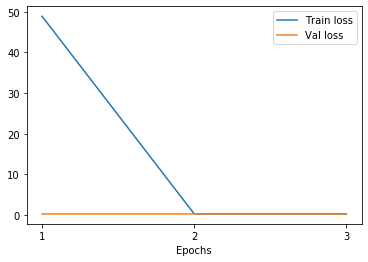

In [72]:
axis = list(range(1, len(train_losses) + 1))
train_loss_log=train_losses
validation_loss_log=valid_losses
plt.plot(axis, train_losses, label = 'Train loss');
plt.plot(axis, valid_losses, label = 'Val loss');
plt.legend();
plt.xticks(axis);
plt.xlabel('Epochs');


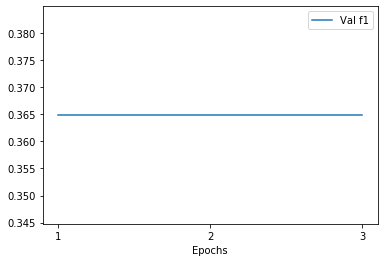

In [73]:
plt.plot(axis, valid_f1s, label = 'Val f1');
plt.legend();
plt.xticks(axis);
plt.xlabel('Epochs');

# Model Evaluation

In [74]:
#Create prediciton using the output from both BERT and ResNet
def predict(model, data_loader, data_iterator, test = False, treshold = 0.4):
    
    model.eval();
    preds = [];
    dist=[];
    
    with torch.no_grad():
        
        if not test:
            #Generate prediction ResNet
            for step, ((imgs,_),(txt,_)) in enumerate(zip(data_loader,data_iterator)):
                imgs = cuda(imgs); txt = cuda(txt)
                prd = model(imgs, txt)
                prob = torch.sigmoid(prd)
                dist.append(prd)
                preds.append(prob)
                
        else:
            #Generate prediction ResNet
            for step, ((imgs),(txt)) in enumerate(zip(data_loader,data_iterator)):
                imgs = cuda(imgs); txt = cuda(txt)
                prd = model(imgs, txt)
                prob = torch.sigmoid(prd)
                dist.append(prd)
                preds.append(prob)
                
        #record predictions from BERT and ResNet
        result = torch.cat(preds)       
        result = torch.ge(result, treshold).int().cpu().numpy()
        
        dist = torch.cat(dist).float().cpu().numpy()
        
        #if the prediction is blank we will use the 95th percentile prediction
        k = 0
        for i in result:
            if all(i == 0):
                holder = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] 
                idx = np.where(dist[k] > np.percentile(dist[k],95))

                for j in idx[0]:
                    holder[j] = 1
                    
                result[k] = holder 
            k = k + 1  
        
    return result

In [ ]:
best_model.cuda();

#predict the validation dataset
predictions = predict(best_model, validation_loader, validation_iterator, False)

In [ ]:
predictions

In [ ]:
#get dictionary of ids
ids = df['ImageID'][-len(validation_data):].values
dictionary = dict([cur_id, ''] for cur_id in ids)

nonzero_idx, nonzero_classes = np.nonzero(predictions)

for cur_id, cur_class in zip(np.array(ids)[nonzero_idx],nonzero_classes):
    cur_class = cur_class+1; dictionary[cur_id] += str(cur_class) + ' '

#move preiction to pandas dataframe and convert the labels
val_result = (pd.DataFrame.from_dict(dictionary, orient='index', columns=['Labels']).reset_index().rename({'index':'ImageID'}, axis=1))

In [ ]:
#check the first 10 predictions
val_result.head(10)

In [ ]:
#Check the f1 score best f1:0.8456247611769202
sk_f1_score(res[val_index], predictions, average='micro')

# Predict the Test Dataset

In [ ]:
#load the test dataset
path = '../Input/'+test
with open(path) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
#check the test dataset
df_test

In [ ]:
#conver the dataset to pytorch accepted format
test_data = LoadImages(df_test['ImageID'], None, '../Input/data/', test_transformers, test = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, num_workers=0)

testimages = next(iter(test_loader))

#visualise the dataset
fig, axes = plt.subplots(figsize=(12, 12), nrows=5)
for i in range(5):
    axe1 = axes[i] 
    imshow(testimages[i], ax=axe1, normalize=True)
    plt.tight_layout()

In [ ]:
# create collate_fn function for BERT training
def collate_fn_test(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) -> Tuple[torch.LongTensor, torch.LongTensor]:
    x,_ = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    return x.to(device)

collate_fn_test = partial(collate_fn_test, device=device)

#conver the dataset to pytorch accepted format
test_dataset = LoadText(tokenizer, df_test['Caption'].values, None, True)
BATCH_SIZE = 10
test_iterator = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn_test)

In [ ]:
%%time
#get the best BERT and ResNet models
best_model.cuda();

#predict the test dataset
predictions = predict(best_model, test_loader, test_iterator, True)

#get dictionary of ids
ids = df_test['ImageID'][-len(test_data):].values
dictionary = dict([cur_id, ''] for cur_id in ids)

nonzero_idx, nonzero_classes = np.nonzero(predictions)

#convert the prediction into labels from one hot encoding
for cur_id, cur_class in zip(np.array(ids)[nonzero_idx],nonzero_classes):
    cur_class = cur_class+1;
    dictionary[cur_id] += str(cur_class) + ' '

#move preiction to pandas dataframe and convert the labels
test_result = (pd.DataFrame.from_dict(dictionary, orient='index', columns=['Labels']).reset_index().rename({'index':'ImageID'}, axis=1))

In [ ]:
#remove the last spacing on labels column
test_result['Labels'] = test_result['Labels'].str.strip()

In [ ]:
#View the prediction output
test_result.head(10)

In [ ]:
test_result.to_csv('../Output/Predicted_labels.txt', index=False, sep=',', mode='w')

In [ ]:
##Only for Kaggle Submission
# #save the result to csv
# test_result.to_csv('../Output/Predicted_labels.csv', index=False)